<a href="https://colab.research.google.com/github/stanislavlia/DeepLearning.AI-specialization/blob/main/U_net_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
import tensorflow as tf
from keras.layers import Dense, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout
from keras.layers import Input, concatenate
import numpy as np
import matplotlib.pyplot as plt



U-Net, named for its U-shape, was originally created in 2015 for tumor detection, but in the years since has become a very popular choice for other semantic segmentation tasks.

U-Net builds on a previous architecture called the Fully Convolutional Network, or FCN, which replaces the dense layers found in a typical CNN with a transposed convolution layer that upsamples the feature map back to the size of the original input image, while preserving the spatial information. This is necessary because the dense layers destroy spatial information (the "where" of the image), which is an essential part of image segmentation tasks. An added bonus of using transpose convolutions is that the input size no longer needs to be fixed, as it does when dense layers are used.

Unfortunately, the final feature layer of the FCN suffers from information loss due to downsampling too much. It then becomes difficult to upsample after so much information has been lost, causing an output that looks rough.

U-Net improves on the FCN, using a somewhat similar design, but differing in some important ways. Instead of one transposed convolution at the end of the network, it uses a matching number of convolutions for downsampling the input image to a feature map, and transposed convolutions for upsampling those maps back up to the original input image size. It also adds skip connections, to retain information that would otherwise become lost during encoding. Skip connections send information to every upsampling layer in the decoder from the corresponding downsampling layer in the encoder, capturing finer information while also keeping computation low. These help prevent information loss, as well as model overfitting.

# U-Net architecture for Image Segmentation

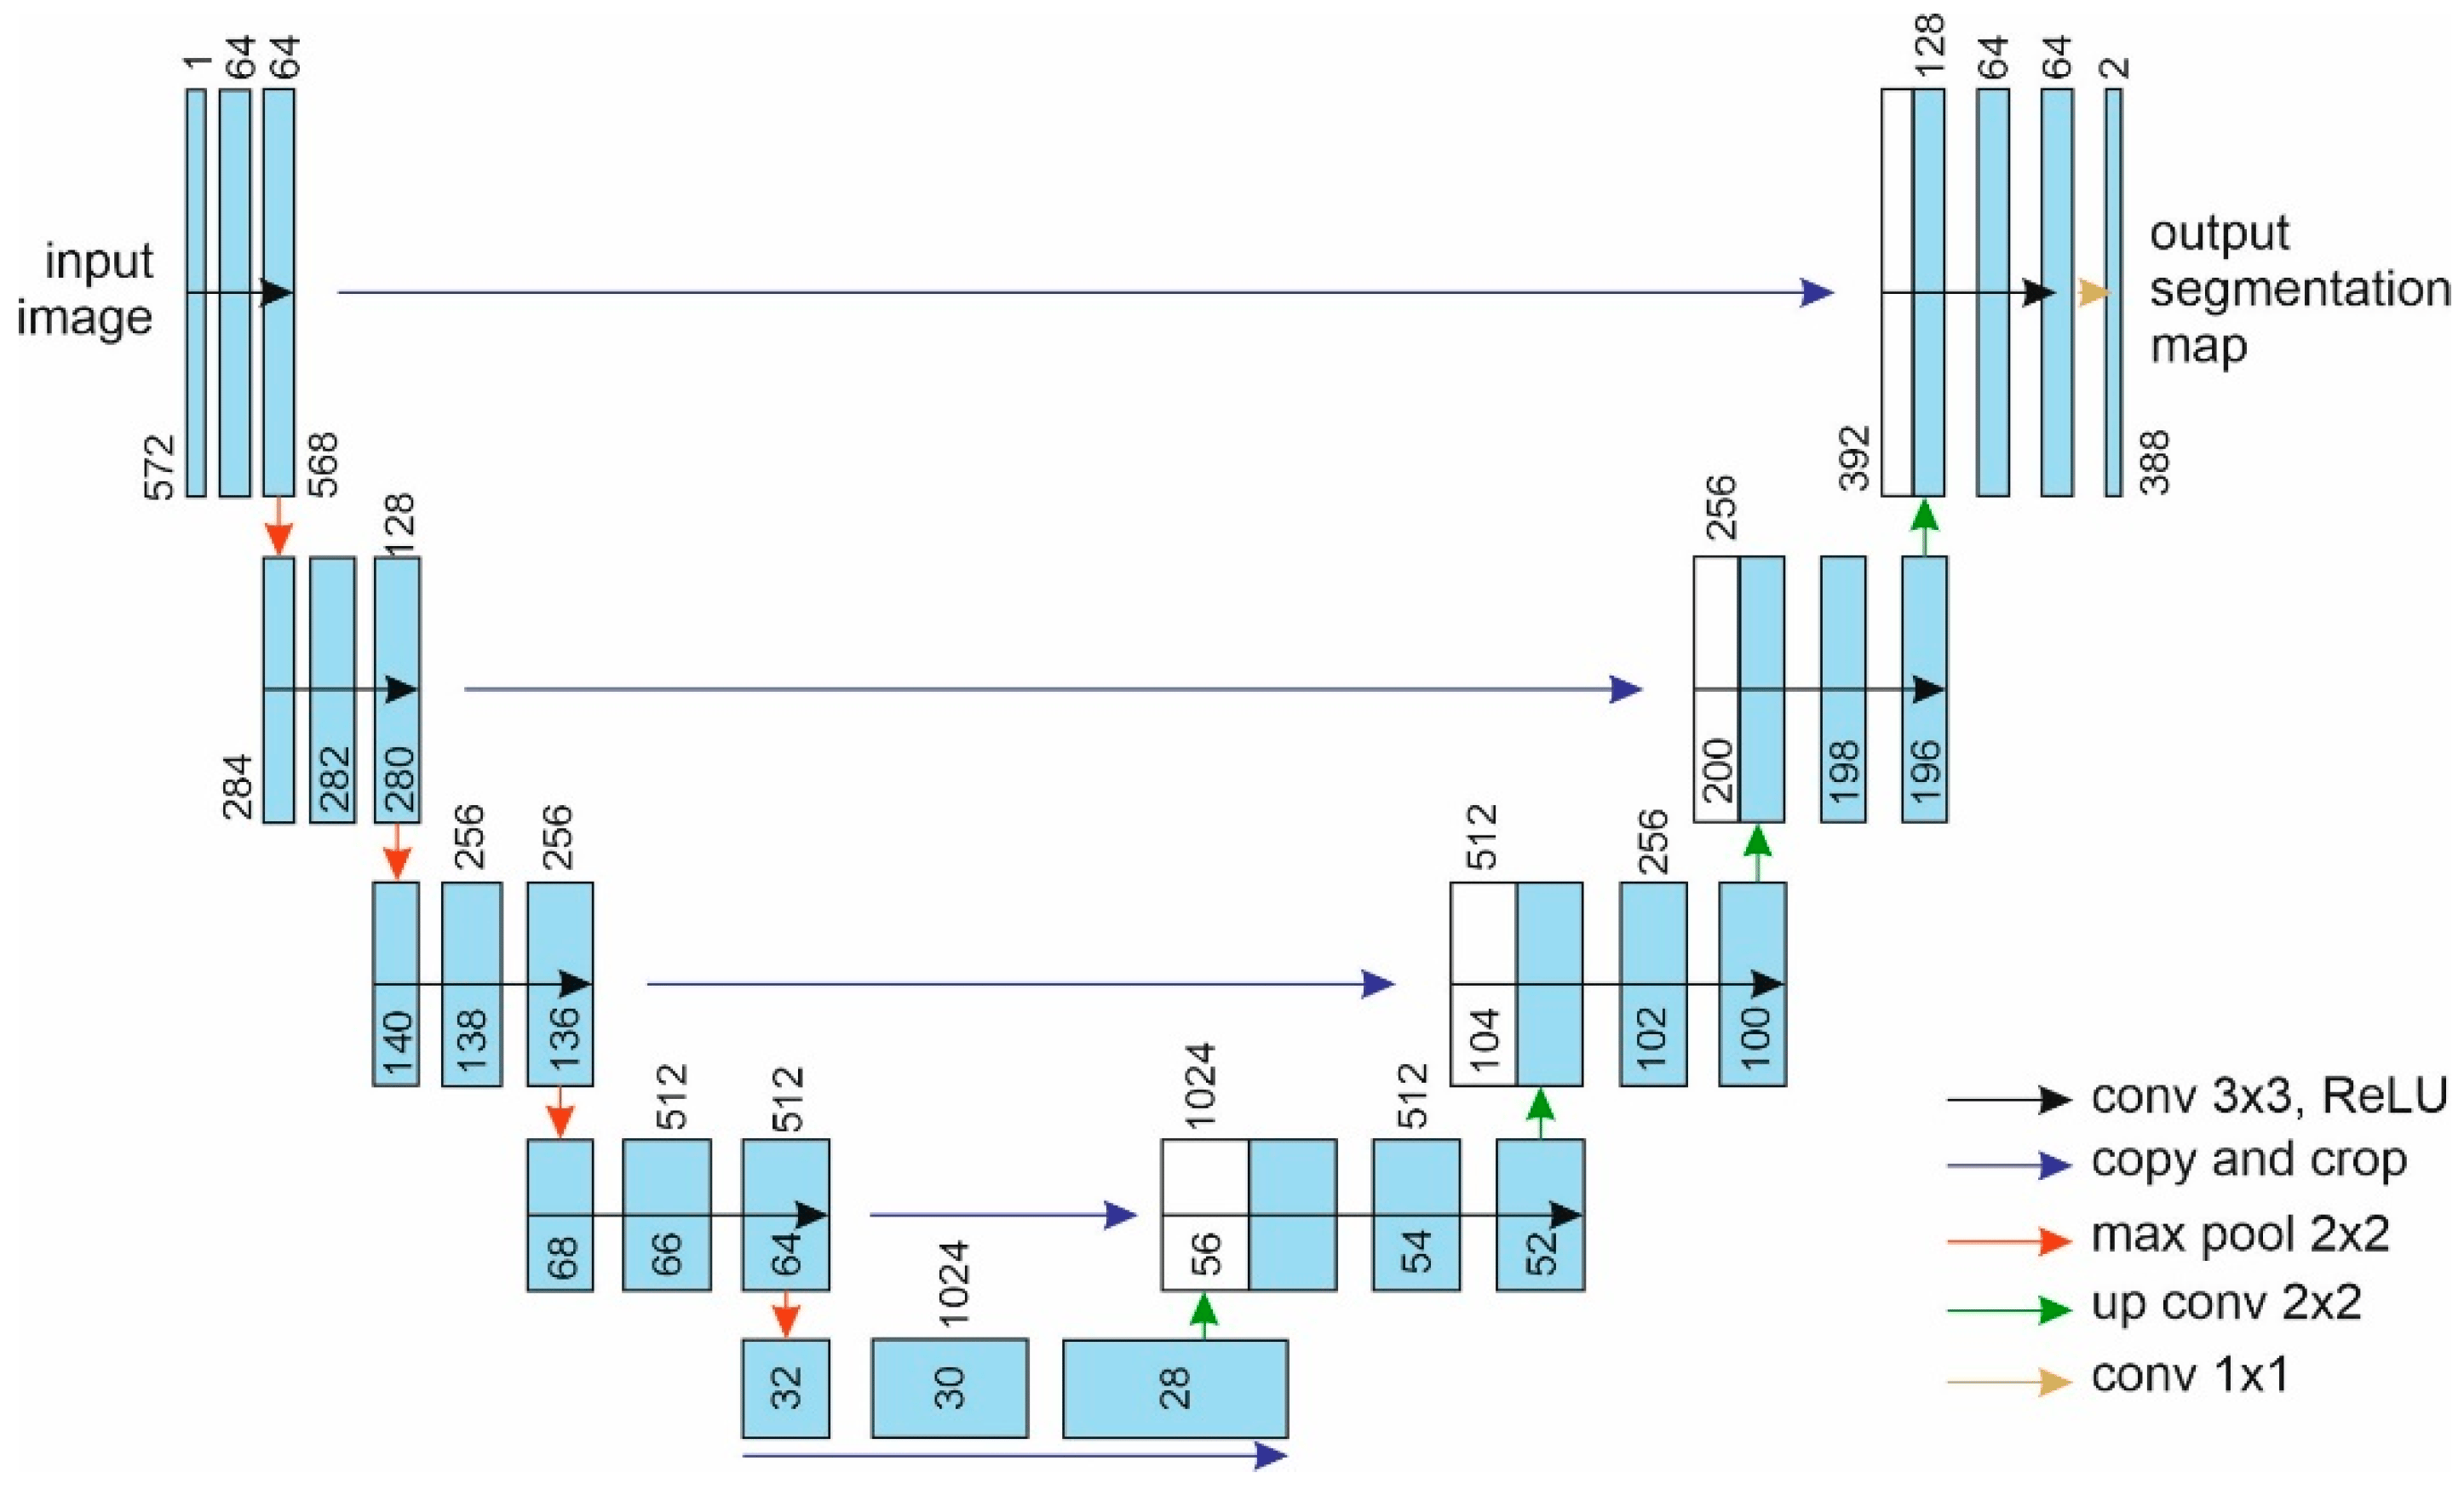

## Let's implement conv_block which reduces the dims of picture

The block is following:
- Convolution with n_filters, each filter = (3,3), same padding, activ=RELU
- Convolution with n_filters, each filter = (3,3), same padding, activ=RELU
- Dropout layer to prevent overfitting (optional)
- Max Pooling layer with kernel = (2,2) to reduce the dimension (optional)

In [58]:
def conv_block(inputs, n_filters, dropout=0.0 , pooling=True):
    """
    inputs - previous layer
    n_filters - number of filters to use in Convolution
    dropout - dropout probability
    pooling - flag to include MaxPooling

    """

    #1st Convolution
    conv =  Conv2D(filters=n_filters,
                   kernel_size=3,
                    padding="same", activation="relu")(inputs)

    #2nd Convolution
    conv =  Conv2D(filters=n_filters,
                   kernel_size=3,
                    padding="same", activation="relu")(conv)
    #Keep our unpooled layer to use it later as skip connection
    skip_connection = conv
    if dropout > 0:
        conv = Dropout(dropout)(conv)

    if pooling:
        next_layer = MaxPooling2D(2)(conv)

    else:
        next_layer = conv



    return next_layer, skip_connection



Now, we need to implement decoder block (upsampling block) which will expand
dimensions towards dims of original image.

- Transpose Convolution with n_filters, each filter=(3,3),  stride=2, padding = "same"
- Concatenating result from *transpose conv* and *skip conection part*
- Convolution with n_filters, each filter = (3,3), same padding, activ=RELU
- Convolution with n_filters, each filter = (3,3), same padding, activ=RELU


In [59]:
def upsampling_block(prev_layer, skip_connection, n_filters):
    """
    prev_layer - tensor, result of previous layer
    skip_connection - tensor, information we kept from corresponding encoder block
    n_filters - filters used in Convolutions
    """

    upsampled = Conv2DTranspose(filters=n_filters,
                                kernel_size=3,
                                 strides=(2,2),
                                 padding="same") (prev_layer)

    #Stack 2 blocks by channels axis
    merged_layer = concatenate([upsampled, skip_connection], axis=3)

    conv =  Conv2D(filters=n_filters,
                   kernel_size=3,
                    padding="same", activation="relu")(merged_layer)

    conv =  Conv2D(filters=n_filters,
                   kernel_size=3,
                    padding="same", activation="relu")(conv)


    return conv


## Putting it all together into U-Net model



In [66]:
def u_net_model(input_shape, n_filters, n_classes):

    inputs = Input(input_shape)

    #Encoding (convolutional) part

    #Each next block of convolution has double amount of filters
    #We pass first element of output since it is input for next layer
    conv_block1 = conv_block(inputs, n_filters)
    conv_block2 = conv_block(conv_block1[0], n_filters * 2)
    conv_block3 = conv_block(conv_block2[0], n_filters * 4)
    conv_block4 = conv_block(conv_block3[0], n_filters * 8, dropout=0.4)

    #Middle block between two parts
    conv_block5 = conv_block(conv_block4[0], n_filters * 16, dropout=0.4, pooling=False)

    #Upsampling part
    # Use previous layer result and corresponding skip connection term
    # Descrease n_filters by 2

    up_block1 = upsampling_block(conv_block5[0], conv_block4[1], n_filters * 8)

    up_block2 = upsampling_block(up_block1, conv_block3[1], n_filters * 4)
    up_block3 = upsampling_block(up_block2, conv_block2[1], n_filters * 2)
    up_block4 = upsampling_block(up_block3, conv_block1[1], n_filters)



    conv = Conv2D(filters=n_filters,
                         kernel_size=3, padding="same",
                         activation="relu") (up_block4)

    #Use 1x1 Convolution to get num_channels = num_of_classes
    conv_final = Conv2D(filters=n_classes, kernel_size=1,
                         padding="same", activation="relu") (conv)


    model = tf.keras.Model(inputs=inputs, outputs=conv_final)

    return model




NOTE:

In order to use U-net, we need to resize the image with height and width
devisible by 16 (because we decrease dims of picture by 2 times in 4 iterations)

In [67]:
image_height = 1024
image_width = 1600
channels = 3

input_shape = (image_height, image_width, channels)

In [68]:
unet = u_net_model(input_shape, n_filters=32, n_classes=5)

In [69]:
unet.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_20 (InputLayer)       [(None, 1024, 1600, 3)]      0         []                            
                                                                                                  
 conv2d_231 (Conv2D)         (None, 1024, 1600, 32)       896       ['input_20[0][0]']            
                                                                                                  
 conv2d_232 (Conv2D)         (None, 1024, 1600, 32)       9248      ['conv2d_231[0][0]']          
                                                                                                  
 max_pooling2d_65 (MaxPooli  (None, 512, 800, 32)         0         ['conv2d_232[0][0]']          
 ng2D)                                                                                      